<a href="https://colab.research.google.com/github/abazabaaa/colab_tutorial/blob/main/saturation_binding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.


from IPython.utils import io
import os
import subprocess
import requests
import hashlib
import tarfile
import time
import tqdm.notebook
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
total = 75
if not os.path.isdir("/opt/conda"):
  try:
    with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
        with io.capture_output() as captured:
            %shell rm -rf /opt/conda
            %shell wget -q -P /tmp \
              https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
                && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
                && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
            pbar.update(17)


            PATH=%env PATH
            %env PATH=/opt/conda/bin:{PATH}
            %shell conda update -qy conda \
                && conda install -qy -c conda-forge \
                  python=3.7 \
                  lmfit
                  
            pbar.update(58)

  except subprocess.CalledProcessError:
    print(captured)
    raise

# --- Python imports ---
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')
import numpy as np
from lmfit import Minimizer, Parameters, report_fit
from lmfit import Model
import matplotlib.pyplot as plt

def mod1(combodata, ns, kd, bmax): # not all parameters are used here
        return ((bmax*combodata)/(combodata+kd)) + (combodata * ns)

def mod2(combodata, ns, kd, bmax): # not all parameters are used here
        return combodata * ns

def fit_function(combodata, bmax, kd, ns):
    
    extract1 = combodata[:len(y1)] # first data
    extract2 = combodata[len(y2):] # second data
    
#     model1 = ((bmax * extract1))/(extract1 + kd) + (extract1 * ns)
#     model2 = extract2 * ns
    
    model1 = mod1(extract1, ns, kd, bmax)
    model2 = mod2(extract2, ns, kd, bmax)
    
    
    resid1 = model1
    resid2 = model2
#     print(np.concatenate((resid1, resid2)))
#     return np.subtract(model1, model2)
    return np.concatenate((resid1, resid2))        

In [21]:
#@title Enter the following parameters: ⬇️
name_of_hot_ligand = 'hy-2-15'  #@param {type:"string"}

amount_cold_ligand_to_define_ns_um = 1 #@param {type:"number"}


tissue_type = 'brain' #@param [1, "brain", "cells", "protein"] {type:"string"}

species = 'human' #@param [1, "human", "nhp", "rat", "mouse"] {type:"string"}

diagnosis = 'AD' #@param [1, "None", "AD", "PD", "MSA"] {type:"string"}

assay_volume_ml = 0.15  #@param {type:"number"}


specific_activity_ci_mmol = 82  #@param {type:"number"}

counter_efficiency = 0.45  #@param {type:"number"}

total_protein_ug = 50 #@param {type:"number"}

ligand_denominator = assay_volume_ml*specific_activity_ci_mmol*counter_efficiency*2.2
bound_denominator = specific_activity_ci_mmol*counter_efficiency*2.22*total_protein_ug

In [7]:
## Paste the total counts (CPM)

total_cpm = [499, 795, 1123, 1572, 1965, 2319, 3368, 4493, 6292]

## Paste the NS counts (CPM)
ns_cpm = [177, 239, 271, 433, 714, 975, 1649, 2671, 4987]

## Paste the counts added
cpm_added_input = [9114, 12435, 17777, 25275, 38373, 63302, 104414, 247323, 399872]

ligand_conc_pm = np.subtract(cpm_added_input, total_cpm)/ligand_denominator

print(f'The ligand concentration in pM is {ligand_conc_pm}')


The ligand concentration in pM is [  707.48131724   955.9004681   1367.66034327  1946.53855629
  2989.8989899   5008.04795927  8298.10298103 19941.69335633
 32321.58988257]


In [29]:
y1 = np.array(total_cpm)
y2 = np.array(ns_cpm)
comboY = np.append(y1, y2)
h = ligand_conc_pm
comboX = np.append(h, h)
#@title Raw fields
gmodel = Model(fit_function)
frac_non_specific_bound = 0.1 #@param {type:"raw"}
frac_non_specific_bound_max = 0.5 #@param {type:"raw"}
gmodel.set_param_hint('ns', value=frac_non_specific_bound, min=0, max=frac_non_specific_bound_max)


bmax_cpm_guess = 2000 #@param {type:"raw"}
bmax_cpm_max = 6000 #@param {type:"raw"}
gmodel.set_param_hint('bmax', value=bmax_cpm_guess, min=0, max=bmax_cpm_max)

kd_pM_guess = 2000 #@param {type:"raw"}
kd_pM_max = 10000 #@param {type:"raw"}
gmodel.set_param_hint('kd', value=kd_pM_guess, min=0, max=kd_pM_max)
pars = gmodel.make_params()
gmodel = Model(fit_function)
result = gmodel.fit(comboY, pars, combodata=comboX)

bmax_out = result.params['bmax']
kd_out = result.params['kd']
ns_out = result.params['ns']

bmax_fit = result.params['bmax'].value
kd_fit = result.params['kd'].value
ns_fit = result.params['ns'].value
print(f'Bmax (CPM) = {bmax_out}')
print(f'Kd (pM) = {kd_out}')
print(f'frac lig non-specifically bound = {ns_out}')
result

Bmax (CPM) = <Parameter 'bmax', value=1918.0661820832377 +/- 244, bounds=[0:6000]>
Kd (pM) = <Parameter 'kd', value=1302.0425130733292 +/- 533, bounds=[0:10000]>
frac lig non-specifically bound = <Parameter 'ns', value=0.14659480784336187 +/- 0.00622, bounds=[0:0.5]>


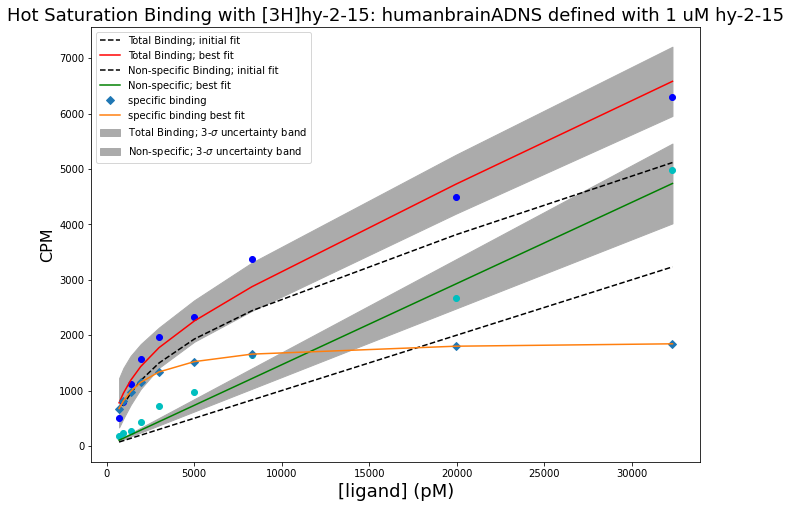

name,value,standard error,relative error,initial value,min,max,vary
bmax,1918.06618,244.218759,(12.73%),2000,0.00000000,6000.00000,True
kd,1302.04251,533.223044,(40.95%),2000,0.00000000,10000.0000,True
ns,0.14659481,0.00621540,(4.24%),0.1,0.00000000,0.50000000,True


In [31]:
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(121)

y_fit_1 = mod1(h, ns_fit, kd_fit, bmax_fit) # first data set, first equation
y_fit_2 = mod2(h, ns_fit, kd_fit, bmax_fit) # second data set, second equation


dely = result.eval_uncertainty(sigma=3)
plt.fill_between(h, result.best_fit[:len(y1)]-dely[:len(y1)], result.best_fit[:len(y1)]+dely[:len(y1)], color="#ABABAB",
                 label='Total Binding; 3-$\sigma$ uncertainty band')

plt.plot(comboX[:len(y1)], comboY[:len(y1)], 'bo')
plt.plot(h, result.init_fit[:len(y1)], 'k--', label='Total Binding; initial fit')
plt.plot(h, result.best_fit[:len(y1)], 'r-', label='Total Binding; best fit')


plt.fill_between(h, result.best_fit[len(y2):]-dely[len(y2):], result.best_fit[len(y2):]+dely[len(y2):], color="#ABABAB",
                 label='Non-specific; 3-$\sigma$ uncertainty band')

plt.plot(comboX[len(y2):], comboY[len(y2):], 'co')
plt.plot(h, result.init_fit[len(y2):], 'k--', label='Non-specific Binding; initial fit')
plt.plot(h, result.best_fit[len(y2):], 'g-', label='Non-specific; best fit')


ax.set_title(f'Hot Saturation Binding with [3H]{name_of_hot_ligand}: {species}{tissue_type}{diagnosis}\
NS defined with {amount_cold_ligand_to_define_ns_um} uM {name_of_hot_ligand}', fontsize=18)
specific = np.subtract(y_fit_1, y_fit_2)
plt.plot(h, specific, 'D', label='specific binding')
plt.plot(h, specific, label='specific binding best fit')

plt.xlabel('[ligand] (pM)', fontsize=18)
plt.ylabel('CPM', fontsize=16)

plt.legend(loc='best')
plt.show()
result.params